##Esse é um notebook que constroe um jogo da velha que aprende a jogar com Deep Reinforcement Learning.

###Instalação das bibliotecas faltantes do google colab.

In [0]:
!pip install keras-rl2

###Importação das bibliotecas que serão usadas durante o código.

In [0]:
import numpy as np
import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import time
import math

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
from keras.callbacks.callbacks import LambdaCallback
from rl.callbacks import TrainIntervalLogger, FileLogger

###Criação da função que define o modelo de Redes Neurais Artificiais que será utilizado.

In [0]:
def cria_modelo(n_parametros, n_acoes, input_shape, janela_aprendizado, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=(janela_aprendizado,) + input_shape))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    return rna

###Criação do embiente customizado para o agente, contruido seguindo os padrões dos ambientes do Gym (biblioteca de inteligência artificial criada pela OpenAI para reinforcement learning).

In [0]:
class JogoDaVelhaEnv(gym.Env):
    def __init__(self, teste=False):
        self.campo = None
        self.n_acoes = 9
        self.n_parametros = 9
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_acoes,), dtype=np.int8)
        self.teste = teste
        self.reset()

    def observacao(self):
        obs = np.empty(self.n_acoes, dtype=np.int8)
        for i in range(self.n_acoes):
            obs[i] = self.campo[i]
        return obs

    def jogada_oponente(self):
        valido = False
        while not valido:
            jogada = np.random.choice(self.n_acoes)
            if self.campo[jogada] == 0:
                self.campo[jogada] = -1
                valido = True

    def acabou(self, campo_ref=[]):

        if len(campo_ref) == 0:
            campo_ref = self.observacao()
        acabou = False
        resultado = 0
        
        for i in range(3):
            if campo_ref[0 + (i * 3)] + campo_ref[1 + (i * 3)] + campo_ref[2 + (i * 3)] in [3, -3]: #confere as linhas
                resultado = campo_ref[0 + (i * 3)] + campo_ref[1 + (i * 3)] + campo_ref[2 + (i * 3)]
            if campo_ref[0 + i] + campo_ref[3 + i] + campo_ref[6 + i] in [3, -3]: #confere as colunas
                resultado = campo_ref[0 + i] + campo_ref[3 + i] + campo_ref[6 + i]
            
        if campo_ref[0] + campo_ref[4] + campo_ref[8] in [3, -3]:
            resultado = campo_ref[0] + campo_ref[4] + campo_ref[8]
        if campo_ref[2] + campo_ref[4] + campo_ref[6] in [3, -3]:
            resultado = campo_ref[2] + campo_ref[4] + campo_ref[6]

        resultado = int(resultado / 3)
        if resultado != 0:
            acabou = True
        else:
            acabou = True
            for i in range(9):
                if self.campo[i] == 0:
                    acabou = False

        return acabou, resultado

    def step(self, acao):

        recompensa_max = 0
        estado_antes = self.observacao()
        recompensa = 0
        valido = False
        acabou = True
        resultado = 0

        if self.campo[acao] == 0:
            self.campo[acao] = 1
            valido = True
            acabou, resultado = self.acabou()
            if acabou and resultado == 1:
                recompensa = 100
        else:
            recompensa = -100

        #confere se tem alguma jogada que podia ganhar
        if recompensa == 0:
            for jogada_ia in range(9):
                if estado_antes[jogada_ia] == 0:
                    estado_ref = []
                    for k in range(len(estado_antes)):
                        estado_ref.append(estado_antes[k])
                    estado_ref[jogada_ia] = 1
                    a, v = self.acabou(estado_ref)
                    if a and v == 1:
                        recompensa_max = 100

        if valido and not acabou:
            self.jogada_oponente()
            acabou, resultado = self.acabou()
            if acabou and resultado == -1:
                recompensa = -100

        #caso nao podia ganhar, confere se tinha alguma jogada que previnia a vitoria do oponente
        if recompensa_max == 0 and recompensa == -100 and valido:
            qnt_vitorias = 0
            for jogada_op in range(9):
                if estado_antes[jogada_op] == 0:
                    estado_ref = []
                    for k in range(len(estado_antes)):
                        estado_ref.append(estado_antes[k])
                    estado_ref[jogada_op] = -1
                    a, v = self.acabou(estado_ref)
                    if a and v == -1:
                        qnt_vitorias += 1
            if qnt_vitorias >= 2:
                recompensa_max = -100

        return self.observacao(), recompensa, acabou, {'recompensa_max':recompensa_max}
        #return self.observacao(), recompensa, acabou, {}

    def reset(self):
        self.campo = np.zeros(self.n_parametros)
        comeca = bool(np.random.choice(2))
        if not self.teste and not comeca:
            self.jogada_oponente()
        return self.observacao()

    def render(self, mode='human'):
        estado = self.observacao()
        for i in range(len(estado)):
            if( i ) % 3 == 0:
                print()
            else:
                print('| ', end='')
            simbolo_maquina = 'O'
            simbolo_jogador = 'X'
            if estado[i] == -1:
                print(simbolo_jogador + ' ', end='')
            elif estado[i] == 1:
                print(simbolo_maquina + ' ', end='')
            else:
                print('- ', end='')
        print()

###Criação de uma política customizada para trabalhar com decaimento do epsilon.

In [5]:
from rl.policy import Policy

class MaxBoltzmannQPolicyEpsDecay(Policy):
    def __init__(self, eps=.1, tau=1., clip=(-500., 500.), n_episodios):
        super(MaxBoltzmannQPolicy, self).__init__()
        self.eps = eps
        self.tau = tau
        self.clip = clip
        self.n_episodios = n_episodios
        self.episodio = 

    def select_action(self, q_values):
        assert q_values.ndim == 1
        q_values = q_values.astype('float64')
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            exp_values = np.exp(np.clip(q_values / self.tau, self.clip[0], self.clip[1]))
            probs = exp_values / np.sum(exp_values)
            action = np.random.choice(range(nb_actions), p=probs)
        else:
            action = np.argmax(q_values)
        return action

    def get_config(self):
        config = super(MaxBoltzmannQPolicy, self).get_config()
        config['eps'] = self.eps
        config['tau'] = self.tau
        config['clip'] = self.clip
        return config

SyntaxError: ignored

###Definição de todas as variáveis importantes do código e o treino do agente.

In [11]:
np.random.seed(10)

ambiente = JogoDaVelhaEnv() #cria o ambiente para o jogo
n_parametros = ambiente.n_parametros #define o numero de entradas da rede
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape
janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
n_steps = 500000

memoria = SequentialMemory(limit=50000, window_length=janela_aprendizado)
modelo = cria_modelo( 9, 9, input_shape, janela_aprendizado, 0.3 )
#politica = MaxBoltzmannQPolicy( eps=0.5, tau=1.5 ) #tau grande -> Aleatorio, tau pequeno -> Greedy
politica = EpsGreedyQPolicy( eps=0.2 )
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy() )
metricas = ['accuracy']
agente.compile(optimizers.Adam(), metrics=metricas)

rasultados_treino = []
save_log_callback_treino = LambdaCallback( on_batch_end=lambda batch,logs: rasultados_treino.append( logs ) )
log_interval = n_steps / 20
historia_treino = agente.fit(env=ambiente, nb_steps=n_steps, visualize=False, verbose=1, callbacks=[save_log_callback_treino], log_interval=log_interval)
#historia_treino = agente.fit(env=ambiente, nb_steps=n_steps, visualize=False, verbose=0, callbacks=[save_log_callback_treino])

agente.save_weights('dqn.h5f', overwrite=True)

Training for 500000 steps ...
Interval 1.0 (0 steps performed)
25000/25000 [==============================] - 234s 9ms/step - reward: 1.8680
8027 episodes - episode_reward: 5.818 [-100.000, 100.000] - loss: 1653.866 - accuracy: 0.423 - mean_q: 0.601 - recompensa_max: 2.904

Interval 2.0 (25000 steps performed)
25000/25000 [==============================] - 262s 10ms/step - reward: 9.2760
7815 episodes - episode_reward: 29.674 [-100.000, 100.000] - loss: 1557.311 - accuracy: 0.546 - mean_q: 0.681 - recompensa_max: 2.564

Interval 3.0 (50000 steps performed)
25000/25000 [==============================] - 305s 12ms/step - reward: 8.7000
7771 episodes - episode_reward: 27.989 [-100.000, 100.000] - loss: 1528.000 - accuracy: 0.593 - mean_q: 0.708 - recompensa_max: 2.472

Interval 4.0 (75000 steps performed)
 1381/25000 [>.............................] - ETA: 4:29 - reward: 8.1825done, took 816.462 seconds


###Visualização dos resultados do treino.

In [0]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

nm_metricas = ['recompensa', 'regret', 'loss'] + metricas[:-1] + ['mean_q']

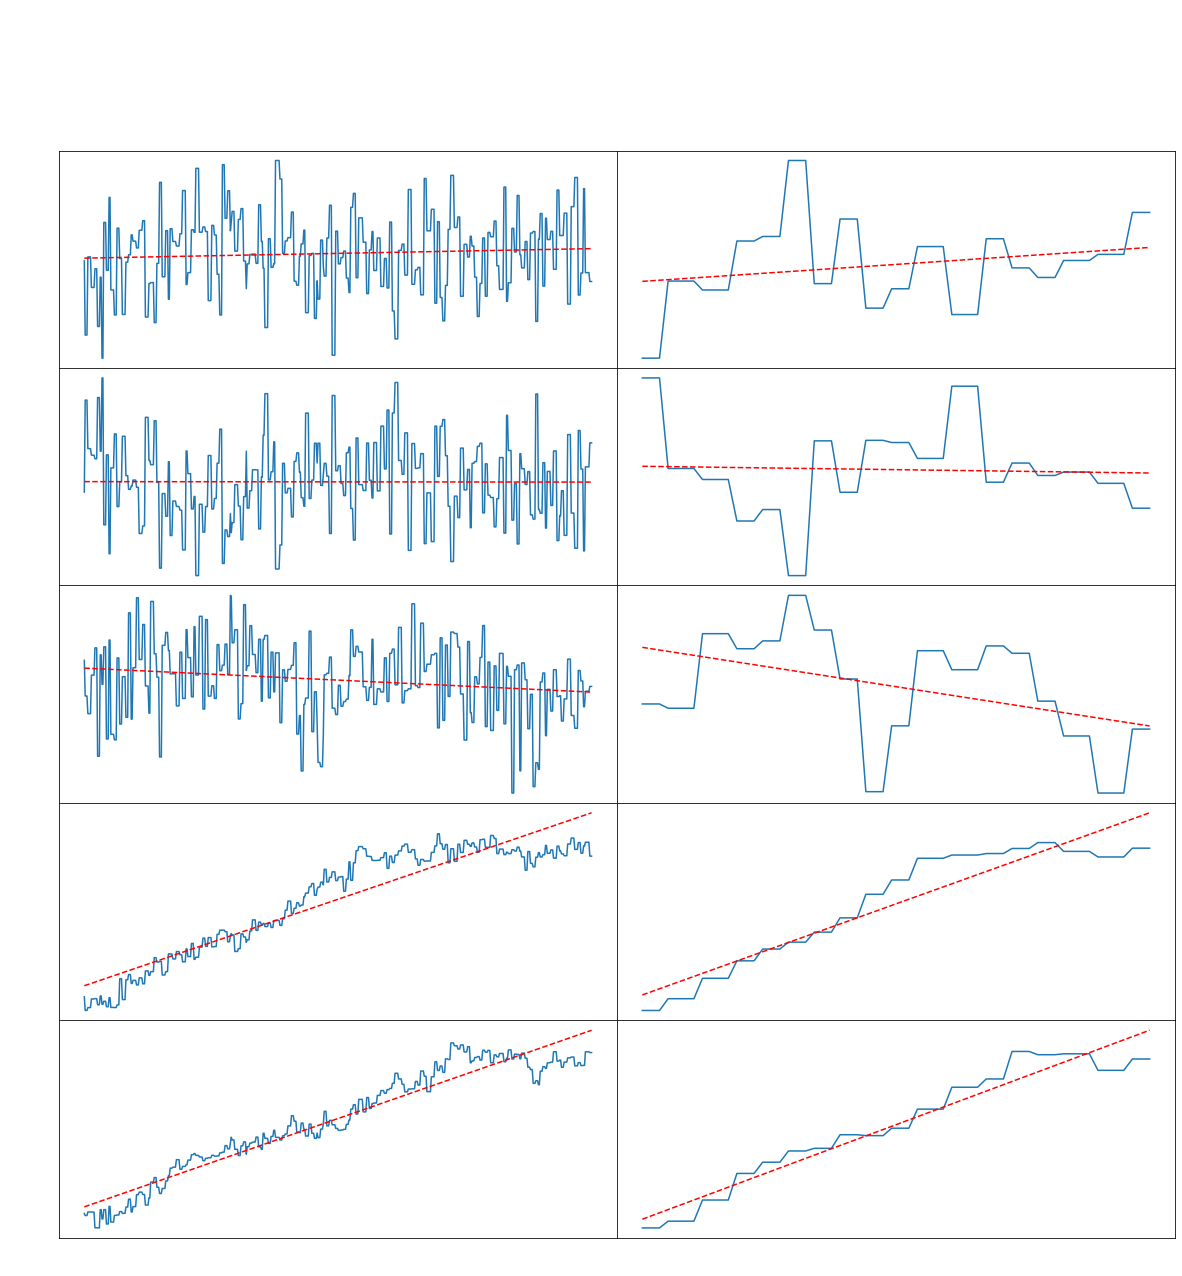

In [8]:
divisores = [100, 1000]
result = rasultados_treino
tipo = 'treino'
pular_n_episodios = n_steps / 100

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(20,20))
fig.suptitle('Medias por episodios do {}'.format(tipo))
for metrica_i in range(len(nm_metricas)):
    nm_metrica = nm_metricas[metrica_i]
    axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:
        hist_metricas = []
        metricas_media = []
        metricas_ref = []
        ref = pular_n_episodios
        comecar = 0
        while result[comecar]['episode'] < pular_n_episodios:
            comecar += 1

        for i in range(comecar, len(result) + 1):
            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
            if len(result) == i or result[i]['episode'] != ref:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                ref += 1
                metricas_ref = []
            if len(result) != i:
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                elif metrica_i == 1: #regret
                    metricas_ref.append( result[i]['info']['recompensa_max'] - result[i]['reward'] )
                else: #outras metricas
                    if math.isnan(result[i]['metrics'][metrica_i-2]):
                        metricas_ref.append( 0 )
                    else:
                        metricas_ref.append( result[i]['metrics'][metrica_i-2] )

        #plota grafico
        x_plot = np.arange(len(metricas_media))
        axs[metrica_i][grafico].set(xlabel='episodio / {}'.format(divisor))
        axs[metrica_i][grafico].plot(x_plot, metricas_media)
        #linha de tendencia
        z = np.polyfit(x_plot, metricas_media, 1)
        p = np.poly1d(z)
        axs[metrica_i][grafico].plot(x_plot, p(x_plot),"r--")
        axs[metrica_i][grafico].label_outer()
        grafico += 1

fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto

###Testando o agente.

In [9]:
print( "IA = 'O' e oponente = 'X'" )
agente.test(ambiente, nb_episodes=5, visualize=True)

IA = 'O' e oponente = 'X'
Testing for 5 episodes ...

- | X | - 
- | - | - 
- | - | O 

- | X | X 
- | - | - 
O | - | O 

- | X | X 
- | - | - 
O | O | O 
Episode 1: reward: 100.000, steps: 3

X | - | - 
- | - | - 
- | - | O 

X | - | - 
- | - | - 
O | X | O 

X | - | - 
X | - | O 
O | X | O 

X | - | O 
X | - | O 
O | X | O 
Episode 2: reward: 100.000, steps: 4

- | - | - 
- | X | - 
- | X | O 

X | - | - 
- | X | O 
- | X | O 

X | - | O 
- | X | O 
- | X | O 
Episode 3: reward: 100.000, steps: 3

X | - | X 
- | - | - 
- | - | O 

X | - | X 
X | - | - 
O | - | O 

X | - | X 
X | - | - 
O | O | O 
Episode 4: reward: 100.000, steps: 3

- | - | X 
- | - | - 
- | - | O 

- | - | X 
- | - | - 
O | X | O 

O | - | X 
X | - | - 
O | X | O 

O | - | X 
X | X | O 
O | X | O 

O | - | X 
X | X | O 
O | X | O 
Episode 5: reward: -100.000, steps: 5


###Visualização dos resultados do teste.


In [10]:
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=metricas)
agente.load_weights('dqn.h5f')

resultados_teste = []
save_log_callback_teste = LambdaCallback(on_batch_end=lambda batch,logs: resultados_teste.append(logs))

historia_teste = agente.fit(env=ambiente, nb_steps=n_steps/10, visualize=False, verbose=1, callbacks=[save_log_callback_teste], log_interval=log_interval/10)
#historia_teste = agente.fit(env=ambiente, nb_steps=n_steps/10, visualize=False, verbose=0, callbacks=[save_log_callback_teste])

NameError: ignored

In [0]:
divisores = [10, 100]
result = resultados_teste
tipo = 'teste'
pular_n_episodios = 1500

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(20,20))
fig.suptitle('Medias por episodios do {}'.format(tipo))
for metrica_i in range(len(nm_metricas)):
    nm_metrica = nm_metricas[metrica_i]
    axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:
        hist_metricas = []
        metricas_media = []
        metricas_ref = []
        ref = pular_n_episodios
        comecar = 0
        while result[comecar]['episode'] < pular_n_episodios:
            comecar += 1

        for i in range(comecar, len(result) + 1):
            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
            if len(result) == i or result[i]['episode'] != ref:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                ref += 1
                metricas_ref = []
            if len(result) != i:
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                elif metrica_i == 1: #regret
                    metricas_ref.append( result[i]['info']['recompensa_max'] - result[i]['reward'] )
                else: #outras metricas
                    if math.isnan(result[i]['metrics'][metrica_i-2]):
                        metricas_ref.append( 0 )
                    else:
                        metricas_ref.append( result[i]['metrics'][metrica_i-2] )

        #plota grafico
        x_plot = np.arange(len(metricas_media))
        axs[metrica_i][grafico].set(xlabel='episodio / {}'.format(divisor))
        axs[metrica_i][grafico].plot(x_plot, metricas_media)
        #linha de tendencia
        z = np.polyfit(x_plot, metricas_media, 1)
        p = np.poly1d(z)
        axs[metrica_i][grafico].plot(x_plot, p(x_plot),"r--")
        axs[metrica_i][grafico].label_outer()
        grafico += 1

fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto

###Jogando contra o agente treinado.

In [0]:
def jogada_agente(agente, estado):
    estado_reshape = [estado]
    saida = agente.compute_q_values( estado_reshape )
    jogada = np.argmax( saida )
    return jogada

#jogar contra a maquina
ambiente = JogoDaVelhaEnv( teste=True ) #cria o ambiente para o jogo
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam())
agente.load_weights('dqn.h5f')

vez_do_jogador = False
acabou = False
simbolo_jogador = 'X'

while not acabou:
    if vez_do_jogador:
        #jogada do jogador
        jogada_valida = False
        while not jogada_valida:
            jogada = int(input('campo a jogar: '))
            if ambiente.campo[ jogada ] != 0:
                print('campo inválido')
            else:
                ambiente.campo[ jogada ] = -1
                jogada_valida = True
                acabou, resultado = ambiente.acabou()

    else:
        #jogada da maquina
        jogada_valida = False
        jogada = jogada_agente( agente, ambiente.observacao() )
        if ambiente.campo[ jogada ] == 0:
            ambiente.campo[ jogada ] = 1
            acabou, resultado = ambiente.acabou()
        else:
            print('jogada invalida da IA')
            acabou = True
            resultado = -1
    
    vez_do_jogador = not vez_do_jogador
    ambiente.render()

ganhador = None #define uma variavel para quem ganhou o jogo
if resultado == -1: #se o resultado for 1
    ganhador = 'Voce ganhou' #o ganhador foi a IA
elif resultado == 1: #se o resultado for -1
    ganhador = 'A IA ganhou' #o ganhador foi o oponente aleatorio
else: #se o resultado for 0
    ganhador = 'Deu velha' #o jogo deu velha

print(ganhador)